In [69]:
import pandas as pd
import numpy as np
import networkx as nx
import operator as op
import itertools
import matplotlib.pyplot as plt
import numpy.linalg
import cmath
import multiprocessing
import itertools
import scipy.optimize as optimize
from tabulate import tabulate

%matplotlib inline

In [80]:
def pretty_df(df):
  print(tabulate(df, headers='keys', tablefmt="fancy_grid"))

In [40]:
#Dummy Data set
dummy=pd.DataFrame([['t', 'c', 1988],
                    ['c', 'g', 1989],
                    ['a', 'c', 1989],
                    ['g', 'a', 1990],
                    ['a', 't', 1991],
                    ['t', 'l', 1992],
                    ['a', 'b', 1993],
                    ['c', 'b', 1993],
                    ['g', 'k', 1994],
                    ['p', 'k', 1994],
                    ['a', 'c', 1995],
                    ['p', 'c', 1995],
                    ['g', 'c', 1995],
                    ['l', 'n', 1995],
                    ['c', 't', 1995],
                    ['p', 'r', 1996],
                    ['p', 'k', 1996],
                    ['t', 'a', 1996],
                    ['r', 'l', 1997],
                    ['g', 'w', 1997],
                    ['r', 'c', 1998],
                    ['p', 'q', 1998],
                    ['r', 'g', 1998],
                    ['a', 'p', 1999],
                    ['r', 'p', 1998]],columns = ["source_id", "target_id", "timestamp"])    

dummy.source_id = dummy.source_id.astype(str)
dummy.target_id = dummy.target_id.astype(str)
t_min=dummy.timestamp.min()
t_max=dummy.timestamp.max()
N=10
dataset = dummy

In [3]:
def create_intervals(dataset,N):


    t_min=dataset.timestamp.min()
    t_max=dataset.timestamp.max()


    dt=(t_max-t_min)/N
    
    intervals=[]
    for j in range(0,N):

        #Start of time interval
        tj=t_min + j*dt
        
        #End of time interval
        tj1=t_min +(j+1)*dt

        intervals.append([int(tj),int(tj1)])

    return(intervals)

In [4]:
class graph(object):
    def __init__(self,dataset, t0,t1):
        self.t0 = t0
        self.t1 = t1
        self.dataset = dataset
        self.create_graph()
        self.interval=[t0,t1]
        
    def create_graph(self):
        self.batch = self.create_batch()
        self.graph = nx.from_pandas_edgelist(self.batch, 'source_id', 'target_id')
        

    def create_batch(self):
        
        df_indexes=[]
        index = 0
        self.dataset = self.dataset.reset_index(drop=True)
            
        if self.t1 == self.dataset.timestamp.max():
            while index < len(self.dataset)and self.dataset.timestamp[index]<=self.t1 :
                if self.dataset.timestamp[index]>=self.t0:
                    df_indexes.append(index)
                    
                index = index +1

            batch = self.dataset.iloc[df_indexes]

            return(batch)

        else:
            while index < len(self.dataset)and self.dataset.timestamp[index]<self.t1 :
                if self.dataset.timestamp[index]>=self.t0:
                    df_indexes.append(index)
                    
                index = index +1

            batch = self.dataset.iloc[df_indexes]
            
            return(batch)

In [5]:
def vertices_intersection(dataset,t0,t1,t2):
    
    #Create two graphs
    G1 = graph(dataset,t0,t1) #for t-1,t
    G2 = graph(dataset,t1,t2) #for t, t+1
    
    S1=set(G1.graph.nodes())
    S2=set(G2.graph.nodes())
    #print(S1,S2)
    return set.intersection(S1,S2) #Return the common nodes

In [148]:
def E_prev_set(dataset,t0,t1,t2):
    
    #Calculate the intersection
    G1 = graph(dataset,t0,t1) #for t-1,t
    G2 = graph(dataset,t1,t2) #for t, t+1
    
    S1 = set(G1.graph.nodes())
    S2 = set(G2.graph.nodes())
    
    intersection = set.intersection(S1,S2)
    #Calculate the the intersection vertices in [t-1, t)
    df = pd.DataFrame(columns = ["source_id", "target_id", "timestamp"])
    for row in G1.batch.itertuples():
        if (row.source_id in intersection and row.target_id in intersection) and (t0<=row.timestamp<t1):
            #print(row.target_id,row.source_id)
            df = pd.concat([df,pd.DataFrame([row])],axis = 0)

    if not df.empty:
        del df['Index']
        df=df.reset_index(drop=True)

        #Calculate the intersection edges in [t-1, t)
        G= graph(df,t0,t1)

        return set(G.graph.edges())

In [149]:
def E_next_set(dataset,t0,t1,t2):
    
    #Calculate the intersection
    G1 = graph(dataset,t0,t1) #for t-1,t
    G2 = graph(dataset,t1,t2) #for t, t+1
    
    S1 = set(G1.graph.nodes())
    S2 = set(G2.graph.nodes())
    
    intersection = set.intersection(S1,S2)

    #Calculate the the intersection vertices in [t, t+1)
    df = pd.DataFrame(columns = ["source_id", "target_id", "timestamp"])
    for row in G2.batch.itertuples():
        if (row.source_id in intersection and row.target_id in intersection) and (t1<=row.timestamp<t2):
            df = pd.concat([df,pd.DataFrame([row])],axis = 0)
    
    if not df.empty:
        del df['Index']
        df=df.reset_index(drop=True)

        #Calculate the intersection edges in [t, t+1)
        G= graph(df,t1,t2)

        return set(G.graph.edges())

In [150]:
def vertices_volume(dataset,N):
    
    time_intervals = create_intervals(dataset,N)
    #print(time_intervals)
    intersection_list=[]
    i = 0
    for time_interval in time_intervals:
        if i < (len(time_intervals)-1):
            dt = time_interval[1] - time_interval[0]
            intersection_list.append(len(vertices_intersection(dataset, time_interval[0], time_interval[1], time_interval[1] + dt)))
    #print(vertices_intersection(dataset, 1994, 1996, 1998))
        
    return(intersection_list)

In [151]:
def jaccard_distance(dataset,t0,t1,t2):
    
    vertices_list = sorted(vertices_intersection(dataset,t0,t1,t2))
    edges_set = E_prev_set(dataset,t0,t1,t2)

    #Create the graph Object
    Gprev=nx.Graph()
    
    #Add the common vertices for the [t-1, t+1]
    Gprev.add_nodes_from(vertices_list)
    #Take the edges of the [t-1, t) interval
    if edges_set is not None:
        Gprev.add_edges_from(edges_set)
    
    pos = nx.spring_layout(Gprev)  # positions for all nodes
    # nodes
    nx.draw_networkx_nodes(Gprev, pos, node_size=700)
    # edges
    nx.draw_networkx_edges(Gprev, pos, edgelist=edges_set,
                           width=6)
    # labels
    nx.draw_networkx_labels(Gprev, pos, font_size=20, font_family='sans-serif')
    plt.axis('off')
    plt.show()
    
    jacc = list(nx.jaccard_coefficient(Gprev))
    df=pd.DataFrame(0,index=vertices_list, columns=vertices_list)
    for i in range(0,len(jacc)):
        df.loc[jacc[i][0],jacc[i][1]] = jacc[i][2]
        df.loc[jacc[i][1],jacc[i][0]] = jacc[i][2]
        
    return(df)

In [152]:
def calculate_label(dataset,t0,t1,t2):
    
    vertices_list = sorted(vertices_intersection(dataset,t0,t1,t2))
    edges_set_prev = E_prev_set(dataset,t0,t1,t2)
    edges_set_next = E_next_set(dataset,t0,t1,t2)
    label=pd.DataFrame('-',index=vertices_list, columns=vertices_list)
    if edges_set_prev is not None:
        edges_prev=list(edges_set_prev)
        for i in range(0,len(edges_prev)):
            label.loc[edges_prev[i][0],edges_prev[i][1]] = 0
            label.loc[edges_prev[i][1],edges_prev[i][0]] = 0
    if edges_set_next is not None:
        edges_next=list(edges_set_next)
        for i in range(0,len(edges_next)):
            label.loc[edges_next[i][0],edges_next[i][1]] = '+'
            label.loc[edges_next[i][1],edges_next[i][0]] = '+'
    for i in range(0,len(vertices_list)):
        label.loc[vertices_list[i],vertices_list[i]] = 0
    return label

In [153]:
def calculate_jaccard_distance(dataset, N):
    
    time_intervals = create_intervals(dataset,N)
    for time_interval in time_intervals:

        dt = time_interval[1] - time_interval[0]

        #Common Neighbors Distance Calculation
        matrix=jaccard_distance(dataset, time_interval[0], time_interval[1], time_interval[1] + dt)
        label=calculate_label(dataset, time_interval[0], time_interval[1], time_interval[1] + dt)
        if (matrix is not None) and (not matrix.empty):
            print(time_interval)
            pretty_df(matrix)
            pretty_df(label)

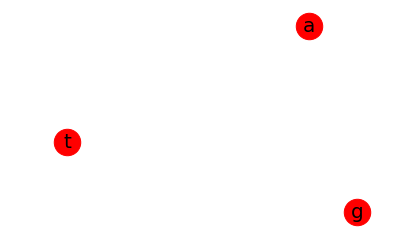

[1988, 1990]
╒════╤═════╤═════╤═════╕
│    │   a │   g │   t │
╞════╪═════╪═════╪═════╡
│ a  │   0 │   0 │   0 │
├────┼─────┼─────┼─────┤
│ g  │   0 │   0 │   0 │
├────┼─────┼─────┼─────┤
│ t  │   0 │   0 │   0 │
╘════╧═════╧═════╧═════╛
╒════╤═════╤═════╤═════╕
│    │ a   │ g   │ t   │
╞════╪═════╪═════╪═════╡
│ a  │ 0   │ +   │ +   │
├────┼─────┼─────┼─────┤
│ g  │ +   │ 0   │ -   │
├────┼─────┼─────┼─────┤
│ t  │ +   │ -   │ 0   │
╘════╧═════╧═════╧═════╛


C:\Users\faisal\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


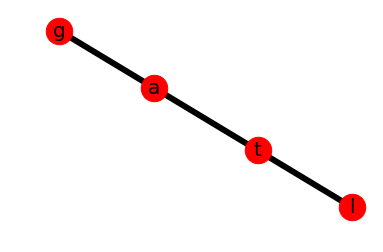

[1990, 1993]
╒════╤═════╤═════╤═════╤═════╕
│    │   a │   g │   l │   t │
╞════╪═════╪═════╪═════╪═════╡
│ a  │ 0   │ 0   │ 0.5 │ 0   │
├────┼─────┼─────┼─────┼─────┤
│ g  │ 0   │ 0   │ 0   │ 0.5 │
├────┼─────┼─────┼─────┼─────┤
│ l  │ 0.5 │ 0   │ 0   │ 0   │
├────┼─────┼─────┼─────┼─────┤
│ t  │ 0   │ 0.5 │ 0   │ 0   │
╘════╧═════╧═════╧═════╧═════╛
╒════╤═════╤═════╤═════╤═════╕
│    │ a   │ g   │ l   │ t   │
╞════╪═════╪═════╪═════╪═════╡
│ a  │ 0   │ 0   │ -   │ 0   │
├────┼─────┼─────┼─────┼─────┤
│ g  │ 0   │ 0   │ -   │ -   │
├────┼─────┼─────┼─────┼─────┤
│ l  │ -   │ -   │ 0   │ 0   │
├────┼─────┼─────┼─────┼─────┤
│ t  │ 0   │ -   │ 0   │ 0   │
╘════╧═════╧═════╧═════╧═════╛


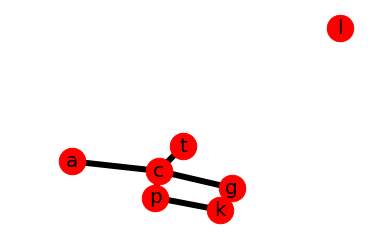

[1993, 1996]
╒════╤═════╤═════╤═════╤═════╤═════╤═════╤═════╕
│    │   a │   c │   g │   k │   l │   p │   t │
╞════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╡
│ a  │ 0   │ 0   │ 0.5 │ 0   │   0 │ 0.5 │ 1   │
├────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┤
│ c  │ 0   │ 0   │ 0   │ 0.5 │   0 │ 0   │ 0   │
├────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┤
│ g  │ 0.5 │ 0   │ 0   │ 0   │   0 │ 1   │ 0.5 │
├────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┤
│ k  │ 0   │ 0.5 │ 0   │ 0   │   0 │ 0   │ 0   │
├────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┤
│ l  │ 0   │ 0   │ 0   │ 0   │   0 │ 0   │ 0   │
├────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┤
│ p  │ 0.5 │ 0   │ 1   │ 0   │   0 │ 0   │ 0.5 │
├────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┤
│ t  │ 1   │ 0   │ 0.5 │ 0   │   0 │ 0.5 │ 0   │
╘════╧═════╧═════╧═════╧═════╧═════╧═════╧═════╛
╒════╤═════╤═════╤═════╤═════╤═════╤═════╤═════╕
│    │ a   │ c   │ g   │ k   │ l   │ p   │ t   │
╞════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╡
│ a  │ 

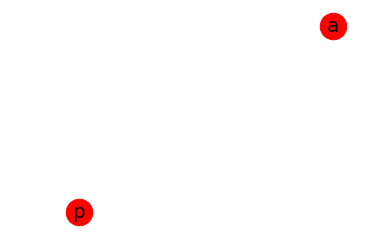

[1996, 1999]
╒════╤═════╤═════╕
│    │   a │   p │
╞════╪═════╪═════╡
│ a  │   0 │   0 │
├────┼─────┼─────┤
│ p  │   0 │   0 │
╘════╧═════╧═════╛
╒════╤═════╤═════╕
│    │ a   │ p   │
╞════╪═════╪═════╡
│ a  │ 0   │ +   │
├────┼─────┼─────┤
│ p  │ +   │ 0   │
╘════╧═════╧═════╛


In [154]:
calculate_jaccard_distance(dataset, 4)